<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#하이퍼파라미터-세팅-및-seed-고정" data-toc-modified-id="하이퍼파라미터-세팅-및-seed-고정-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>하이퍼파라미터 세팅 및 seed 고정</a></span></li><li><span><a href="#학습-데이터-EDA" data-toc-modified-id="학습-데이터-EDA-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>학습 데이터 EDA</a></span></li><li><span><a href="#데이터-전처리-함수-정의-(Dataset)" data-toc-modified-id="데이터-전처리-함수-정의-(Dataset)-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>데이터 전처리 함수 정의 (Dataset)</a></span></li><li><span><a href="#Dataset-정의-및-DataLoader-할당" data-toc-modified-id="Dataset-정의-및-DataLoader-할당-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Dataset 정의 및 DataLoader 할당</a></span><ul class="toc-item"><li><span><a href="#데이터-샘플-시각화-(Show-example-image-and-mask)" data-toc-modified-id="데이터-샘플-시각화-(Show-example-image-and-mask)-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>데이터 샘플 시각화 (Show example image and mask)</a></span></li></ul></li><li><span><a href="#baseline-model" data-toc-modified-id="baseline-model-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>baseline model</a></span><ul class="toc-item"><li><span><a href="#FCN8s-(VGG-imageNet-weight)" data-toc-modified-id="FCN8s-(VGG-imageNet-weight)-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>FCN8s (VGG imageNet weight)</a></span></li></ul></li><li><span><a href="#train,-validation,-test-함수-정의" data-toc-modified-id="train,-validation,-test-함수-정의-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>train, validation, test 함수 정의</a></span></li><li><span><a href="#모델-저장-함수-정의" data-toc-modified-id="모델-저장-함수-정의-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>모델 저장 함수 정의</a></span></li><li><span><a href="#모델-생성-및-Loss-function,-Optimizer-정의" data-toc-modified-id="모델-생성-및-Loss-function,-Optimizer-정의-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>모델 생성 및 Loss function, Optimizer 정의</a></span></li><li><span><a href="#저장된-model-불러오기-(학습된-이후)" data-toc-modified-id="저장된-model-불러오기-(학습된-이후)-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>저장된 model 불러오기 (학습된 이후)</a></span></li><li><span><a href="#submission을-위한-test-함수-정의" data-toc-modified-id="submission을-위한-test-함수-정의-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>submission을 위한 test 함수 정의</a></span></li><li><span><a href="#submission.csv-생성" data-toc-modified-id="submission.csv-생성-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>submission.csv 생성</a></span></li><li><span><a href="#Reference" data-toc-modified-id="Reference-12"><span class="toc-item-num">12&nbsp;&nbsp;</span>Reference</a></span></li></ul></div>

In [1]:
import os
import random
import time
import json
import warnings 
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from utils import *
import cv2

import numpy as np
import pandas as pd

# 전처리를 위한 라이브러리
from pycocotools.coco import COCO
import torchvision
import torchvision.transforms as transforms

import albumentations as A
from albumentations.pytorch import ToTensorV2

# 시각화를 위한 라이브러리
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

plt.rcParams['axes.grid'] = False

print('pytorch version: {}'.format(torch.__version__))
print('GPU 사용 가능 여부: {}'.format(torch.cuda.is_available()))

print(torch.cuda.get_device_name(0))
print(torch.cuda.device_count())

device = "cuda" if torch.cuda.is_available() else "cpu"   # GPU 사용 가능 여부에 따라 device 정보 저장

pytorch version: 1.4.0
GPU 사용 가능 여부: True
Tesla P40
1


## 하이퍼파라미터 세팅 및 seed 고정

In [35]:
batch_size = 16   # Mini-batch size
num_epochs = 20
learning_rate = 0.0001

In [49]:
# seed 고정
random_seed = 21
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
# torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

## 학습 데이터 EDA

In [50]:
%matplotlib inline

dataset_path = '../input/data'
anns_file_path = dataset_path + '/' + 'train.json'

# Read annotations
with open(anns_file_path, 'r') as f:
    dataset = json.loads(f.read())

categories = dataset['categories']
anns = dataset['annotations']
imgs = dataset['images']
nr_cats = len(categories)
nr_annotations = len(anns)
nr_images = len(imgs)

# Load categories and super categories
cat_names = []
super_cat_names = []
super_cat_ids = {}
super_cat_last_name = ''
nr_super_cats = 0
for cat_it in categories:
    cat_names.append(cat_it['name'])
    super_cat_name = cat_it['supercategory']
    # Adding new supercat
    if super_cat_name != super_cat_last_name:
        super_cat_names.append(super_cat_name)
        super_cat_ids[super_cat_name] = nr_super_cats
        super_cat_last_name = super_cat_name
        nr_super_cats += 1

print('Number of super categories:', nr_super_cats)
print('Number of categories:', nr_cats)
print('Number of annotations:', nr_annotations)
print('Number of images:', nr_images)

Number of super categories: 11
Number of categories: 11
Number of annotations: 21116
Number of images: 2617


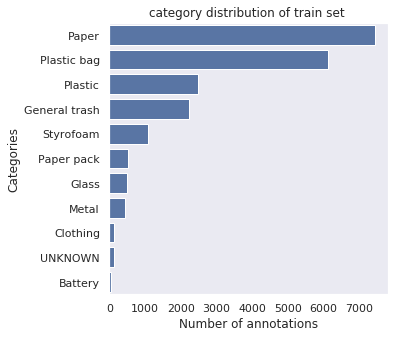

In [51]:
# Count annotations
cat_histogram = np.zeros(nr_cats,dtype=int)
for ann in anns:
    cat_histogram[ann['category_id']] += 1

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(5,5))

# Convert to DataFrame
df = pd.DataFrame({'Categories': cat_names, 'Number of annotations': cat_histogram})
df = df.sort_values('Number of annotations', 0, False)

# Plot the histogram
plt.title("category distribution of train set ")
plot_1 = sns.barplot(x="Number of annotations", y="Categories", data=df, label="Total", color="b")

In [52]:
# category labeling 
sorted_temp_df = df.sort_index()

# background = 0 에 해당되는 label 추가 후 기존들을 모두 label + 1 로 설정
sorted_df = pd.DataFrame(["Backgroud"], columns = ["Categories"])
sorted_df = sorted_df.append(sorted_temp_df, ignore_index=True)

In [53]:
# class (Categories) 에 따른 index 확인 (0~11 : 총 12개)
sorted_df

,Categories,Number of annotations
0,Backgroud,NaN
1,UNKNOWN,128.0
2,General trash,2225.0
3,Paper,7448.0
4,Paper pack,527.0
5,Metal,449.0
6,Glass,488.0
7,Plastic,2472.0
8,Styrofoam,1074.0
9,Plastic bag,6114.0


## 데이터 전처리 함수 정의 (Dataset)

In [54]:
category_names = list(sorted_df.Categories)

def get_classname(classID, cats):
    for i in range(len(cats)):
        if cats[i]['id']==classID:
            return cats[i]['name']
    return "None"

class CustomDataLoader(Dataset):
    """COCO format"""
    def __init__(self, data_dir, mode = 'train', transform = None):
        super().__init__()
        self.mode = mode
        self.transform = transform
        self.coco = COCO(data_dir)
        
    def __getitem__(self, index: int):
        # dataset이 index되어 list처럼 동작
        image_id = self.coco.getImgIds(imgIds=index)
        image_infos = self.coco.loadImgs(image_id)[0]
        
        # cv2 를 활용하여 image 불러오기
        images = cv2.imread(os.path.join(dataset_path, image_infos['file_name']))
        images = cv2.cvtColor(images, cv2.COLOR_BGR2RGB).astype(np.float32)
        images /= 255.0
        
        if (self.mode in ('train', 'val')):
            ann_ids = self.coco.getAnnIds(imgIds=image_infos['id'])
            anns = self.coco.loadAnns(ann_ids)

            # Load the categories in a variable
            cat_ids = self.coco.getCatIds()
            cats = self.coco.loadCats(cat_ids)

            # masks : size가 (height x width)인 2D
            # 각각의 pixel 값에는 "category id + 1" 할당
            # Background = 0
            masks = np.zeros((image_infos["height"], image_infos["width"]))
            # Unknown = 1, General trash = 2, ... , Cigarette = 11
            for i in range(len(anns)):
                className = get_classname(anns[i]['category_id'], cats)
                pixel_value = category_names.index(className)
                masks = np.maximum(self.coco.annToMask(anns[i])*pixel_value, masks)
            masks = masks.astype(np.float32)

            # transform -> albumentations 라이브러리 활용
            if self.transform is not None:
                transformed = self.transform(image=images, mask=masks)
                images = transformed["image"]
                masks = transformed["mask"]
            
            return images, masks, image_infos
        
        if self.mode == 'test':
            # transform -> albumentations 라이브러리 활용
            if self.transform is not None:
                transformed = self.transform(image=images)
                images = transformed["image"]
            
            return images, image_infos
    
    
    def __len__(self) -> int:
        # 전체 dataset의 size를 return
        return len(self.coco.getImgIds())

## Dataset 정의 및 DataLoader 할당

In [55]:
# train.json / validation.json / test.json 디렉토리 설정
train_path = dataset_path + '/train.json'
val_path = dataset_path + '/val.json'
test_path = dataset_path + '/test.json'

# collate_fn needs for batch
def collate_fn(batch):
    return tuple(zip(*batch))

train_transform = A.Compose([
                            A.Resize(224, 224),
                            ToTensorV2()
                            ])

val_transform = A.Compose([
                           A.Resize(224, 224),
                          ToTensorV2()
                          ])

test_transform = A.Compose([
                           A.Resize(224, 224),
                           ToTensorV2()
                           ])

# create own Dataset 1 (skip)
# validation set을 직접 나누고 싶은 경우
# random_split 사용하여 data set을 8:2 로 분할
# train_size = int(0.8*len(dataset))
# val_size = int(len(dataset)-train_size)
# dataset = CustomDataLoader(data_dir=train_path, mode='train', transform=transform)
# train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# create own Dataset 2
# train dataset
train_dataset = CustomDataLoader(data_dir=train_path, mode='train', transform=train_transform)

# validation dataset
val_dataset = CustomDataLoader(data_dir=val_path, mode='val', transform=val_transform)

# test dataset
test_dataset = CustomDataLoader(data_dir=test_path, mode='test', transform=test_transform)


# DataLoader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size,
                                           shuffle=True,
                                           num_workers=4,
                                           collate_fn=collate_fn)

val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                         batch_size=batch_size,
                                         shuffle=False,
                                         num_workers=4,
                                         collate_fn=collate_fn)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          num_workers=4,
                                          collate_fn=collate_fn)

loading annotations into memory...
Done (t=3.33s)
creating index...
index created!
loading annotations into memory...
Done (t=0.81s)
creating index...
index created!
loading annotations into memory...
Done (t=0.96s)
creating index...
index created!


### 데이터 샘플 시각화 (Show example image and mask)

- `train_loader` 
- `val_loader` 
- `test_loader` 

image shape: [3, 224, 224]
mask shape:  [224, 224]
Unique values, category of transformed mask : 
 [{0, 'Backgroud'}, {2, 'General trash'}, {3, 'Paper'}]


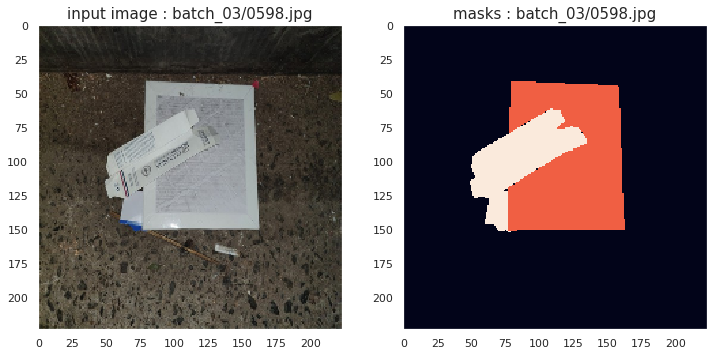

In [56]:
# train_loader의 output 결과(image 및 mask) 확인
for imgs, masks, image_infos in train_loader:
    image_infos = image_infos[0]
    temp_images = imgs
    temp_masks = masks
    
    break

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 12))

print('image shape:', list(temp_images[0].shape))
print('mask shape: ', list(temp_masks[0].shape))
print('Unique values, category of transformed mask : \n', [{int(i),category_names[int(i)]} for i in list(np.unique(temp_masks[0]))])

ax1.imshow(temp_images[0].permute([1,2,0]))
ax1.grid(False)
ax1.set_title("input image : {}".format(image_infos['file_name']), fontsize = 15)

ax2.imshow(temp_masks[0])
ax2.grid(False)
ax2.set_title("masks : {}".format(image_infos['file_name']), fontsize = 15)

plt.show()

image shape: [3, 224, 224]
mask shape:  [224, 224]
Unique values, category of transformed mask : 
 [{0, 'Backgroud'}, {'Glass', 6}, {'Plastic', 7}, {9, 'Plastic bag'}]


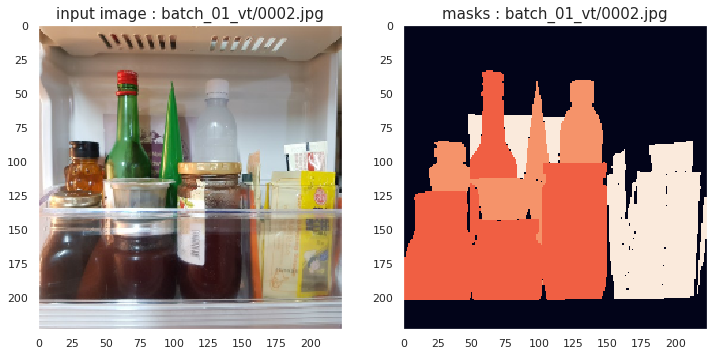

In [57]:
# val_loader의 output 결과(image 및 mask) 확인
for imgs, masks, image_infos in val_loader:
    image_infos = image_infos[0]
    temp_images = imgs
    temp_masks = masks
    
    break

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 12))

print('image shape:', list(temp_images[0].shape))
print('mask shape: ', list(temp_masks[0].shape))

print('Unique values, category of transformed mask : \n', [{int(i),category_names[int(i)]} for i in list(np.unique(temp_masks[0]))])

ax1.imshow(temp_images[0].permute([1,2,0]))
ax1.grid(False)
ax1.set_title("input image : {}".format(image_infos['file_name']), fontsize = 15)

ax2.imshow(temp_masks[0])
ax2.grid(False)
ax2.set_title("masks : {}".format(image_infos['file_name']), fontsize = 15)

plt.show()

image shape: [3, 224, 224]


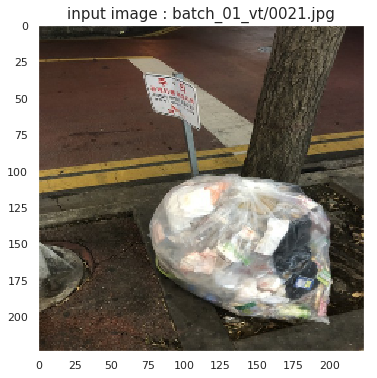

In [58]:
# test_loader의 output 결과(image) 확인
for imgs, image_infos in test_loader:
    image_infos = image_infos[0]
    temp_images = imgs
    
    break

fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))

print('image shape:', list(temp_images[0].shape))

ax1.imshow(temp_images[0].permute([1,2,0]))
ax1.grid(False)
ax1.set_title("input image : {}".format(image_infos['file_name']), fontsize = 15)

plt.show()

## baseline model

### FCN8s (VGG imageNet weight)

In [59]:
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torchvision.models import vgg16

class FCN8s(nn.Module):
    def __init__(self, num_classes):
        super(FCN8s,self).__init__()
        self.pretrained_model = vgg16(pretrained = True)
        features, classifiers = list(self.pretrained_model.features.children()), list(self.pretrained_model.classifier.children())

        self.features_map1 = nn.Sequential(*features[0:17])
        self.features_map2 = nn.Sequential(*features[17:24])
        self.features_map3 = nn.Sequential(*features[24:31])
        
        # Score pool3
        self.score_pool3_fr = nn.Conv2d(256, num_classes, 1)
        
        # Score pool4        
        self.score_pool4_fr = nn.Conv2d(512, num_classes, 1)        
        
        # fc6 ~ fc7
        self.conv = nn.Sequential(nn.Conv2d(512, 4096, kernel_size = 1),
                                  nn.ReLU(inplace=True),
                                  nn.Dropout(),
                                  nn.Conv2d(4096, 4096, kernel_size = 1),
                                  nn.ReLU(inplace=True),
                                  nn.Dropout()
                                  )
        
        # Score
        self.score_fr = nn.Conv2d(4096, num_classes, kernel_size = 1)
        
        # UpScore2 using deconv
        self.upscore2 = nn.ConvTranspose2d(num_classes,
                                           num_classes,
                                           kernel_size=4,
                                           stride=2,
                                           padding=1)
        
        # UpScore2_pool4 using deconv
        self.upscore2_pool4 = nn.ConvTranspose2d(num_classes, 
                                                 num_classes, 
                                                 kernel_size=4,
                                                 stride=2,
                                                 padding=1)
        
        # UpScore8 using deconv
        self.upscore8 = nn.ConvTranspose2d(num_classes, 
                                           num_classes,
                                           kernel_size=16,
                                           stride=8,
                                           padding=4)
    
    def forward(self, x):
        pool3 = h = self.features_map1(x)
        pool4 = h = self.features_map2(h)
        h = self.features_map3(h)
        
        h = self.conv(h)
        h = self.score_fr(h)
       
        score_pool3c = self.score_pool3_fr(pool3)    
        score_pool4c = self.score_pool4_fr(pool4)
        
        # Up Score I
        upscore2 = self.upscore2(h)
        
        # Sum I
        h = upscore2 + score_pool4c
        
        # Up Score II
        upscore2_pool4c = self.upscore2_pool4(h)
        
        # Sum II
        h = upscore2_pool4c + score_pool3c
        
        # Up Score III
        upscore8 = self.upscore8(h)
        
        return upscore8

### HRNET_OCR

In [ ]:
import os
import logging
import functools

import numpy as np

import torch
import torch.nn as nn
import torch._utils
import torch.nn.functional as F

import functools

if torch.__version__.startswith('0'):
    from .sync_bn.inplace_abn.bn import InPlaceABNSync
    BatchNorm2d = functools.partial(InPlaceABNSync, activation='none')
    BatchNorm2d_class = InPlaceABNSync
    relu_inplace = False
else:
    BatchNorm2d_class = BatchNorm2d = torch.nn.BatchNorm2d
    relu_inplace = True

ALIGN_CORNERS = True
BN_MOMENTUM = 0.1
logger = logging.getLogger(__name__)

class ModuleHelper:

    @staticmethod
    def BNReLU(num_features, bn_type=None, **kwargs):
        return nn.Sequential(
            BatchNorm2d(num_features, **kwargs),
            nn.ReLU()
        )

    @staticmethod
    def BatchNorm2d(*args, **kwargs):
        return BatchNorm2d


def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class SpatialGather_Module(nn.Module):
    """
        Aggregate the context features according to the initial 
        predicted probability distribution.
        Employ the soft-weighted method to aggregate the context.
    """
    def __init__(self, cls_num=0, scale=1):
        super(SpatialGather_Module, self).__init__()
        self.cls_num = cls_num
        self.scale = scale

    def forward(self, feats, probs):
        batch_size, c, h, w = probs.size(0), probs.size(1), probs.size(2), probs.size(3)
        probs = probs.view(batch_size, c, -1)
        feats = feats.view(batch_size, feats.size(1), -1)
        feats = feats.permute(0, 2, 1) # batch x hw x c 
        probs = F.softmax(self.scale * probs, dim=2)# batch x k x hw
        ocr_context = torch.matmul(probs, feats)\
        .permute(0, 2, 1).unsqueeze(3)# batch x k x c
        return ocr_context


class _ObjectAttentionBlock(nn.Module):
    '''
    The basic implementation for object context block
    Input:
        N X C X H X W
    Parameters:
        in_channels       : the dimension of the input feature map
        key_channels      : the dimension after the key/query transform
        scale             : choose the scale to downsample the input feature maps (save memory cost)
        bn_type           : specify the bn type
    Return:
        N X C X H X W
    '''
    def __init__(self, 
                 in_channels, 
                 key_channels, 
                 scale=1, 
                 bn_type=None):
        super(_ObjectAttentionBlock, self).__init__()
        self.scale = scale
        self.in_channels = in_channels
        self.key_channels = key_channels
        self.pool = nn.MaxPool2d(kernel_size=(scale, scale))
        self.f_pixel = nn.Sequential(
            nn.Conv2d(in_channels=self.in_channels, out_channels=self.key_channels,
                kernel_size=1, stride=1, padding=0, bias=False),
            ModuleHelper.BNReLU(self.key_channels, bn_type=bn_type),
            nn.Conv2d(in_channels=self.key_channels, out_channels=self.key_channels,
                kernel_size=1, stride=1, padding=0, bias=False),
            ModuleHelper.BNReLU(self.key_channels, bn_type=bn_type),
        )
        self.f_object = nn.Sequential(
            nn.Conv2d(in_channels=self.in_channels, out_channels=self.key_channels,
                kernel_size=1, stride=1, padding=0, bias=False),
            ModuleHelper.BNReLU(self.key_channels, bn_type=bn_type),
            nn.Conv2d(in_channels=self.key_channels, out_channels=self.key_channels,
                kernel_size=1, stride=1, padding=0, bias=False),
            ModuleHelper.BNReLU(self.key_channels, bn_type=bn_type),
        )
        self.f_down = nn.Sequential(
            nn.Conv2d(in_channels=self.in_channels, out_channels=self.key_channels,
                kernel_size=1, stride=1, padding=0, bias=False),
            ModuleHelper.BNReLU(self.key_channels, bn_type=bn_type),
        )
        self.f_up = nn.Sequential(
            nn.Conv2d(in_channels=self.key_channels, out_channels=self.in_channels,
                kernel_size=1, stride=1, padding=0, bias=False),
            ModuleHelper.BNReLU(self.in_channels, bn_type=bn_type),
        )

    def forward(self, x, proxy):
        batch_size, h, w = x.size(0), x.size(2), x.size(3)
        if self.scale > 1:
            x = self.pool(x)

        query = self.f_pixel(x).view(batch_size, self.key_channels, -1)
        query = query.permute(0, 2, 1)
        key = self.f_object(proxy).view(batch_size, self.key_channels, -1)
        value = self.f_down(proxy).view(batch_size, self.key_channels, -1)
        value = value.permute(0, 2, 1)

        sim_map = torch.matmul(query, key)
        sim_map = (self.key_channels**-.5) * sim_map
        sim_map = F.softmax(sim_map, dim=-1)   

        # add bg context ...
        context = torch.matmul(sim_map, value)
        context = context.permute(0, 2, 1).contiguous()
        context = context.view(batch_size, self.key_channels, *x.size()[2:])
        context = self.f_up(context)
        if self.scale > 1:
            context = F.interpolate(input=context, size=(h, w), mode='bilinear', align_corners=ALIGN_CORNERS)

        return context


class ObjectAttentionBlock2D(_ObjectAttentionBlock):
    def __init__(self, 
                 in_channels, 
                 key_channels, 
                 scale=1, 
                 bn_type=None):
        super(ObjectAttentionBlock2D, self).__init__(in_channels,
                                                     key_channels,
                                                     scale, 
                                                     bn_type=bn_type)


class SpatialOCR_Module(nn.Module):
    """
    Implementation of the OCR module:
    We aggregate the global object representation to update the representation for each pixel.
    """
    def __init__(self, 
                 in_channels, 
                 key_channels, 
                 out_channels, 
                 scale=1, 
                 dropout=0.1, 
                 bn_type=None):
        super(SpatialOCR_Module, self).__init__()
        self.object_context_block = ObjectAttentionBlock2D(in_channels, 
                                                           key_channels, 
                                                           scale, 
                                                           bn_type)
        _in_channels = 2 * in_channels

        self.conv_bn_dropout = nn.Sequential(
            nn.Conv2d(_in_channels, out_channels, kernel_size=1, padding=0, bias=False),
            ModuleHelper.BNReLU(out_channels, bn_type=bn_type),
            nn.Dropout2d(dropout)
        )

    def forward(self, feats, proxy_feats):
        context = self.object_context_block(feats, proxy_feats)

        output = self.conv_bn_dropout(torch.cat([context, feats], 1))

        return output


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = BatchNorm2d(planes, momentum=BN_MOMENTUM)
        self.relu = nn.ReLU(inplace=relu_inplace)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = BatchNorm2d(planes, momentum=BN_MOMENTUM)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out = out + residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = BatchNorm2d(planes, momentum=BN_MOMENTUM)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = BatchNorm2d(planes, momentum=BN_MOMENTUM)
        self.conv3 = nn.Conv2d(planes, planes * self.expansion, kernel_size=1,
                               bias=False)
        self.bn3 = BatchNorm2d(planes * self.expansion,
                               momentum=BN_MOMENTUM)
        self.relu = nn.ReLU(inplace=relu_inplace)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out = out + residual
        out = self.relu(out)

        return out


class HighResolutionModule(nn.Module):
    def __init__(self, num_branches, blocks, num_blocks, num_inchannels,
                 num_channels, fuse_method, multi_scale_output=True):
        super(HighResolutionModule, self).__init__()
        self._check_branches(
            num_branches, blocks, num_blocks, num_inchannels, num_channels)

        self.num_inchannels = num_inchannels
        self.fuse_method = fuse_method
        self.num_branches = num_branches

        self.multi_scale_output = multi_scale_output

        self.branches = self._make_branches(
            num_branches, blocks, num_blocks, num_channels)
        self.fuse_layers = self._make_fuse_layers()
        self.relu = nn.ReLU(inplace=relu_inplace)

    def _check_branches(self, num_branches, blocks, num_blocks,
                        num_inchannels, num_channels):
        if num_branches != len(num_blocks):
            error_msg = 'NUM_BRANCHES({}) <> NUM_BLOCKS({})'.format(
                num_branches, len(num_blocks))
            logger.error(error_msg)
            raise ValueError(error_msg)

        if num_branches != len(num_channels):
            error_msg = 'NUM_BRANCHES({}) <> NUM_CHANNELS({})'.format(
                num_branches, len(num_channels))
            logger.error(error_msg)
            raise ValueError(error_msg)

        if num_branches != len(num_inchannels):
            error_msg = 'NUM_BRANCHES({}) <> NUM_INCHANNELS({})'.format(
                num_branches, len(num_inchannels))
            logger.error(error_msg)
            raise ValueError(error_msg)

    def _make_one_branch(self, branch_index, block, num_blocks, num_channels,
                         stride=1):
        downsample = None
        if stride != 1 or \
           self.num_inchannels[branch_index] != num_channels[branch_index] * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.num_inchannels[branch_index],
                          num_channels[branch_index] * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                BatchNorm2d(num_channels[branch_index] * block.expansion,
                            momentum=BN_MOMENTUM),
            )

        layers = []
        layers.append(block(self.num_inchannels[branch_index],
                            num_channels[branch_index], stride, downsample))
        self.num_inchannels[branch_index] = \
            num_channels[branch_index] * block.expansion
        for i in range(1, num_blocks[branch_index]):
            layers.append(block(self.num_inchannels[branch_index],
                                num_channels[branch_index]))

        return nn.Sequential(*layers)

    def _make_branches(self, num_branches, block, num_blocks, num_channels):
        branches = []

        for i in range(num_branches):
            branches.append(
                self._make_one_branch(i, block, num_blocks, num_channels))

        return nn.ModuleList(branches)

    def _make_fuse_layers(self):
        if self.num_branches == 1:
            return None

        num_branches = self.num_branches
        num_inchannels = self.num_inchannels
        fuse_layers = []
        for i in range(num_branches if self.multi_scale_output else 1):
            fuse_layer = []
            for j in range(num_branches):
                if j > i:
                    fuse_layer.append(nn.Sequential(
                        nn.Conv2d(num_inchannels[j],
                                  num_inchannels[i],
                                  1,
                                  1,
                                  0,
                                  bias=False),
                        BatchNorm2d(num_inchannels[i], momentum=BN_MOMENTUM)))
                elif j == i:
                    fuse_layer.append(None)
                else:
                    conv3x3s = []
                    for k in range(i-j):
                        if k == i - j - 1:
                            num_outchannels_conv3x3 = num_inchannels[i]
                            conv3x3s.append(nn.Sequential(
                                nn.Conv2d(num_inchannels[j],
                                          num_outchannels_conv3x3,
                                          3, 2, 1, bias=False),
                                BatchNorm2d(num_outchannels_conv3x3,
                                            momentum=BN_MOMENTUM)))
                        else:
                            num_outchannels_conv3x3 = num_inchannels[j]
                            conv3x3s.append(nn.Sequential(
                                nn.Conv2d(num_inchannels[j],
                                          num_outchannels_conv3x3,
                                          3, 2, 1, bias=False),
                                BatchNorm2d(num_outchannels_conv3x3,
                                            momentum=BN_MOMENTUM),
                                nn.ReLU(inplace=relu_inplace)))
                    fuse_layer.append(nn.Sequential(*conv3x3s))
            fuse_layers.append(nn.ModuleList(fuse_layer))

        return nn.ModuleList(fuse_layers)

    def get_num_inchannels(self):
        return self.num_inchannels

    def forward(self, x):
        if self.num_branches == 1:
            return [self.branches[0](x[0])]

        for i in range(self.num_branches):
            x[i] = self.branches[i](x[i])

        x_fuse = []
        for i in range(len(self.fuse_layers)):
            y = x[0] if i == 0 else self.fuse_layers[i][0](x[0])
            for j in range(1, self.num_branches):
                if i == j:
                    y = y + x[j]
                elif j > i:
                    width_output = x[i].shape[-1]
                    height_output = x[i].shape[-2]
                    y = y + F.interpolate(
                        self.fuse_layers[i][j](x[j]),
                        size=[height_output, width_output],
                        mode='bilinear', align_corners=ALIGN_CORNERS)
                else:
                    y = y + self.fuse_layers[i][j](x[j])
            x_fuse.append(self.relu(y))

        return x_fuse


blocks_dict = {
    'BASIC': BasicBlock,
    'BOTTLENECK': Bottleneck
}


class HighResolutionNet(nn.Module):

    def __init__(self, config, **kwargs):
        global ALIGN_CORNERS
        extra = config.MODEL.EXTRA
        super(HighResolutionNet, self).__init__()
        ALIGN_CORNERS = config.MODEL.ALIGN_CORNERS

        # stem net
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1,
                               bias=False)
        self.bn1 = BatchNorm2d(64, momentum=BN_MOMENTUM)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1,
                               bias=False)
        self.bn2 = BatchNorm2d(64, momentum=BN_MOMENTUM)
        self.relu = nn.ReLU(inplace=relu_inplace)

        self.stage1_cfg = extra['STAGE1']
        num_channels = self.stage1_cfg['NUM_CHANNELS'][0]
        block = blocks_dict[self.stage1_cfg['BLOCK']]
        num_blocks = self.stage1_cfg['NUM_BLOCKS'][0]
        self.layer1 = self._make_layer(block, 64, num_channels, num_blocks)
        stage1_out_channel = block.expansion*num_channels

        self.stage2_cfg = extra['STAGE2']
        num_channels = self.stage2_cfg['NUM_CHANNELS']
        block = blocks_dict[self.stage2_cfg['BLOCK']]
        num_channels = [
            num_channels[i] * block.expansion for i in range(len(num_channels))]
        self.transition1 = self._make_transition_layer(
            [stage1_out_channel], num_channels)
        self.stage2, pre_stage_channels = self._make_stage(
            self.stage2_cfg, num_channels)

        self.stage3_cfg = extra['STAGE3']
        num_channels = self.stage3_cfg['NUM_CHANNELS']
        block = blocks_dict[self.stage3_cfg['BLOCK']]
        num_channels = [
            num_channels[i] * block.expansion for i in range(len(num_channels))]
        self.transition2 = self._make_transition_layer(
            pre_stage_channels, num_channels)
        self.stage3, pre_stage_channels = self._make_stage(
            self.stage3_cfg, num_channels)

        self.stage4_cfg = extra['STAGE4']
        num_channels = self.stage4_cfg['NUM_CHANNELS']
        block = blocks_dict[self.stage4_cfg['BLOCK']]
        num_channels = [
            num_channels[i] * block.expansion for i in range(len(num_channels))]
        self.transition3 = self._make_transition_layer(
            pre_stage_channels, num_channels)
        self.stage4, pre_stage_channels = self._make_stage(
            self.stage4_cfg, num_channels, multi_scale_output=True)

        last_inp_channels = np.int(np.sum(pre_stage_channels))
        ocr_mid_channels = config.MODEL.OCR.MID_CHANNELS
        ocr_key_channels = config.MODEL.OCR.KEY_CHANNELS

        self.conv3x3_ocr = nn.Sequential(
            nn.Conv2d(last_inp_channels, ocr_mid_channels,
                      kernel_size=3, stride=1, padding=1),
            BatchNorm2d(ocr_mid_channels),
            nn.ReLU(inplace=relu_inplace),
        )
        self.ocr_gather_head = SpatialGather_Module(config.DATASET.NUM_CLASSES)

        self.ocr_distri_head = SpatialOCR_Module(in_channels=ocr_mid_channels,
                                                 key_channels=ocr_key_channels,
                                                 out_channels=ocr_mid_channels,
                                                 scale=1,
                                                 dropout=0.05,
                                                 )
        self.cls_head = nn.Conv2d(
            ocr_mid_channels, config.DATASET.NUM_CLASSES, kernel_size=1, stride=1, padding=0, bias=True)

        self.aux_head = nn.Sequential(
            nn.Conv2d(last_inp_channels, last_inp_channels,
                      kernel_size=1, stride=1, padding=0),
            BatchNorm2d(last_inp_channels),
            nn.ReLU(inplace=relu_inplace),
            nn.Conv2d(last_inp_channels, config.DATASET.NUM_CLASSES,
                      kernel_size=1, stride=1, padding=0, bias=True)
        )
        
    def _make_transition_layer(
            self, num_channels_pre_layer, num_channels_cur_layer):
        num_branches_cur = len(num_channels_cur_layer)
        num_branches_pre = len(num_channels_pre_layer)

        transition_layers = []
        for i in range(num_branches_cur):
            if i < num_branches_pre:
                if num_channels_cur_layer[i] != num_channels_pre_layer[i]:
                    transition_layers.append(nn.Sequential(
                        nn.Conv2d(num_channels_pre_layer[i],
                                  num_channels_cur_layer[i],
                                  3,
                                  1,
                                  1,
                                  bias=False),
                        BatchNorm2d(
                            num_channels_cur_layer[i], momentum=BN_MOMENTUM),
                        nn.ReLU(inplace=relu_inplace)))
                else:
                    transition_layers.append(None)
            else:
                conv3x3s = []
                for j in range(i+1-num_branches_pre):
                    inchannels = num_channels_pre_layer[-1]
                    outchannels = num_channels_cur_layer[i] \
                        if j == i-num_branches_pre else inchannels
                    conv3x3s.append(nn.Sequential(
                        nn.Conv2d(
                            inchannels, outchannels, 3, 2, 1, bias=False),
                        BatchNorm2d(outchannels, momentum=BN_MOMENTUM),
                        nn.ReLU(inplace=relu_inplace)))
                transition_layers.append(nn.Sequential(*conv3x3s))

        return nn.ModuleList(transition_layers)

    def _make_layer(self, block, inplanes, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                BatchNorm2d(planes * block.expansion, momentum=BN_MOMENTUM),
            )

        layers = []
        layers.append(block(inplanes, planes, stride, downsample))
        inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(inplanes, planes))

        return nn.Sequential(*layers)

    def _make_stage(self, layer_config, num_inchannels,
                    multi_scale_output=True):
        num_modules = layer_config['NUM_MODULES']
        num_branches = layer_config['NUM_BRANCHES']
        num_blocks = layer_config['NUM_BLOCKS']
        num_channels = layer_config['NUM_CHANNELS']
        block = blocks_dict[layer_config['BLOCK']]
        fuse_method = layer_config['FUSE_METHOD']

        modules = []
        for i in range(num_modules):
            # multi_scale_output is only used last module
            if not multi_scale_output and i == num_modules - 1:
                reset_multi_scale_output = False
            else:
                reset_multi_scale_output = True
            modules.append(
                HighResolutionModule(num_branches,
                                     block,
                                     num_blocks,
                                     num_inchannels,
                                     num_channels,
                                     fuse_method,
                                     reset_multi_scale_output)
            )
            num_inchannels = modules[-1].get_num_inchannels()

        return nn.Sequential(*modules), num_inchannels

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.layer1(x)

        x_list = []
        for i in range(self.stage2_cfg['NUM_BRANCHES']):
            if self.transition1[i] is not None:
                x_list.append(self.transition1[i](x))
            else:
                x_list.append(x)
        y_list = self.stage2(x_list)

        x_list = []
        for i in range(self.stage3_cfg['NUM_BRANCHES']):
            if self.transition2[i] is not None:
                if i < self.stage2_cfg['NUM_BRANCHES']:
                    x_list.append(self.transition2[i](y_list[i]))
                else:
                    x_list.append(self.transition2[i](y_list[-1]))
            else:
                x_list.append(y_list[i])
        y_list = self.stage3(x_list)

        x_list = []
        for i in range(self.stage4_cfg['NUM_BRANCHES']):
            if self.transition3[i] is not None:
                if i < self.stage3_cfg['NUM_BRANCHES']:
                    x_list.append(self.transition3[i](y_list[i]))
                else:
                    x_list.append(self.transition3[i](y_list[-1]))
            else:
                x_list.append(y_list[i])
        x = self.stage4(x_list)

        # Upsampling
        x0_h, x0_w = x[0].size(2), x[0].size(3)
        x1 = F.interpolate(x[1], size=(x0_h, x0_w),
                        mode='bilinear', align_corners=ALIGN_CORNERS)
        x2 = F.interpolate(x[2], size=(x0_h, x0_w),
                        mode='bilinear', align_corners=ALIGN_CORNERS)
        x3 = F.interpolate(x[3], size=(x0_h, x0_w),
                        mode='bilinear', align_corners=ALIGN_CORNERS)

        feats = torch.cat([x[0], x1, x2, x3], 1)

        out_aux_seg = []

        # ocr
        out_aux = self.aux_head(feats)
        # compute contrast feature
        feats = self.conv3x3_ocr(feats)

        context = self.ocr_gather_head(feats, out_aux)
        feats = self.ocr_distri_head(feats, context)

        out = self.cls_head(feats)

        out_aux_seg.append(out_aux)
        out_aux_seg.append(out)

        return out_aux_seg

    def init_weights(self, pretrained='',):
        logger.info('=> init weights from normal distribution')
        for name, m in self.named_modules():
            if any(part in name for part in {'cls', 'aux', 'ocr'}):
                # print('skipped', name)
                continue
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, std=0.001)
            elif isinstance(m, BatchNorm2d_class):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
        if os.path.isfile(pretrained):
            pretrained_dict = torch.load(pretrained, map_location={'cuda:0': 'cpu'})
            logger.info('=> loading pretrained model {}'.format(pretrained))
            model_dict = self.state_dict()
            pretrained_dict = {k.replace('last_layer', 'aux_head').replace('model.', ''): v for k, v in pretrained_dict.items()}  
            print(set(model_dict) - set(pretrained_dict))            
            print(set(pretrained_dict) - set(model_dict))            
            pretrained_dict = {k: v for k, v in pretrained_dict.items()
                               if k in model_dict.keys()}
            # for k, _ in pretrained_dict.items():
                # logger.info(
                #     '=> loading {} pretrained model {}'.format(k, pretrained))
            model_dict.update(pretrained_dict)
            self.load_state_dict(model_dict)
        elif pretrained:
            raise RuntimeError('No such file {}'.format(pretrained))


In [ ]:
from yacs.config import CfgNode as CN

_C = CN()

_C.OUTPUT_DIR = ''
_C.LOG_DIR = ''
_C.GPUS = (0,)
_C.WORKERS = 4
_C.PRINT_FREQ = 20
_C.AUTO_RESUME = False
_C.PIN_MEMORY = True

# Cudnn related params
_C.CUDNN = CN()
_C.CUDNN.BENCHMARK = True
_C.CUDNN.DETERMINISTIC = False
_C.CUDNN.ENABLED = True

# common params for NETWORK
_C.MODEL = CN()
_C.MODEL.NAME = 'seg_hrnet'
_C.MODEL.PRETRAINED = '../model/hrnet_ocr_cs_trainval_8227_torch11.pth'
_C.MODEL.ALIGN_CORNERS = True
_C.MODEL.EXTRA = CN(new_allowed=True)

_C.MODEL.OCR = CN()
_C.MODEL.OCR.MID_CHANNELS = 512
_C.MODEL.OCR.KEY_CHANNELS = 256
_C.MODEL.OCR.DROPOUT = 0.05
_C.MODEL.OCR.SCALE = 1

# DATASET related params
_C.DATASET = CN()
_C.DATASET.NUM_CLASSES = 19

HRNET_48 = CN()
HRNET_48.FINAL_CONV_KERNEL = 1

HRNET_48.STAGE1 = CN()
HRNET_48.STAGE1.NUM_MODULES = 1
HRNET_48.STAGE1.NUM_BRANCHES = 1
HRNET_48.STAGE1.NUM_BLOCKS = [4]
HRNET_48.STAGE1.NUM_CHANNELS = [64]
HRNET_48.STAGE1.BLOCK = 'BOTTLENECK'
HRNET_48.STAGE1.FUSE_METHOD = 'SUM'

HRNET_48.STAGE2 = CN()
HRNET_48.STAGE2.NUM_MODULES = 1
HRNET_48.STAGE2.NUM_BRANCHES = 2
HRNET_48.STAGE2.NUM_BLOCKS = [4, 4]
HRNET_48.STAGE2.NUM_CHANNELS = [48, 96]
HRNET_48.STAGE2.BLOCK = 'BASIC'
HRNET_48.STAGE2.FUSE_METHOD = 'SUM'

HRNET_48.STAGE3 = CN()
HRNET_48.STAGE3.NUM_MODULES = 4
HRNET_48.STAGE3.NUM_BRANCHES = 3
HRNET_48.STAGE3.NUM_BLOCKS = [4, 4, 4]
HRNET_48.STAGE3.NUM_CHANNELS = [48, 96, 192]
HRNET_48.STAGE3.BLOCK = 'BASIC'
HRNET_48.STAGE3.FUSE_METHOD = 'SUM'

HRNET_48.STAGE4 = CN()
HRNET_48.STAGE4.NUM_MODULES = 3
HRNET_48.STAGE4.NUM_BRANCHES = 4
HRNET_48.STAGE4.NUM_BLOCKS = [4, 4, 4, 4]
HRNET_48.STAGE4.NUM_CHANNELS = [48, 96, 192, 384]
HRNET_48.STAGE4.BLOCK = 'BASIC'
HRNET_48.STAGE4.FUSE_METHOD = 'SUM'

_C.MODEL.EXTRA = HRNET_48

In [ ]:
model = HighResolutionNet(_C)
model.init_weights(_C.MODEL.PRETRAINED) #torch.load('../model/hrnet_ocr_cs_trainval_8227_torch11.pth')
model.cls_head = nn.Conv2d(512, 12, kernel_size=(1, 1), stride=(1, 1))
model.aux_head[3] = nn.Conv2d(720, 12, kernel_size=(1, 1), stride=(1, 1))
model.cuda()
model

### SMP

In [60]:
import segmentation_models_pytorch as smp
from pprint import pprint
dir(smp)

['DeepLabV3',
 'DeepLabV3Plus',
 'FPN',
 'Linknet',
 'PAN',
 'PSPNet',
 'Unet',
 'UnetPlusPlus',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '__version__',
 'base',
 'deeplabv3',
 'encoders',
 'fpn',
 'linknet',
 'pan',
 'pspnet',
 'unet',
 'unetplusplus',
 'utils']

In [61]:
model = smp.DeepLabV3Plus(
    encoder_name="timm-regnetx_320",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=12,                      # model output channels (number of classes in your dataset)
)

model.eval()

 )
        (act3): ReLU(inplace=True)
      )
      (b4): Bottleneck(
        (conv1): ConvBnAct(
          (conv): Conv2d(672, 672, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNormAct2d(
            672, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (act): ReLU(inplace=True)
          )
        )
        (conv2): ConvBnAct(
          (conv): Conv2d(672, 672, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=4, bias=False)
          (bn): BatchNormAct2d(
            672, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (act): ReLU(inplace=True)
          )
        )
        (conv3): ConvBnAct(
          (conv): Conv2d(672, 672, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNormAct2d(672, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (act3): ReLU(inplace=True)
      )
      (b5): Bottleneck(
        (conv1): ConvBnAct(
          (conv): Conv2d(

In [62]:
from segmentation_models_pytorch.encoders import get_preprocessing_fn

preprocess_input = get_preprocessing_fn('timm-regnetx_320', pretrained='imagenet')

In [63]:
# 구현된 model에 임의의 input을 넣어 output이 잘 나오는지 test

#model = FCN8s(model = model, num_classes=12)
x = torch.randn([1, 3, 512, 512])
print("input shape : ", x.shape)
out = model(x).to(device)
print("output shape : ", out.size())

model = model.to(device)

input shape :  torch.Size([1, 3, 512, 512])
output shape :  torch.Size([1, 12, 512, 512])


## CutMix

In [64]:
def rand_bbox(size, lam, half=False)->tuple:
    '''
    랜덤한 bounding box의 좌상단,우하단 좌표 반환

    Args:
        size (tuple): batch의 shape
        lam (float): 자를 비율
        half (bool): 절반으로 자름
    '''

    W = size[2]
    H = size[3]

    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    cx = np.random.randint(W)
    cy = np.random.randint(H)
    
    if half==False:
        bbx1 = np.clip(cx - cut_w // 2, 0, W) 
        bby1 = np.clip(cy - cut_h // 2, 0, H)
        bbx2 = np.clip(cx + cut_w // 2, 0, W)
        bby2 = np.clip(cy + cut_h // 2, 0, H)
    else:
        bbx1 = 0
        bby1 = 0
        bbx2 = W//2
        bby2 = H

    return bbx1, bby1, bbx2, bby2

def cutmix(image, mask, alpha, half=False):
    '''
    이미지와 마스크 컷믹스

    Args:
        image (tensor): batch 이미지
        mask (tensor): batch 마스크
        alpha (float): Beta Distribution의 alpha 값
    '''
  
    indices = torch.randperm(image.size(0)) # 배치 크기 입력

    lam = np.clip(np.random.beta(alpha, alpha),0.3,0.4)
    bbx1, bby1, bbx2, bby2 = rand_bbox(image.size(), lam, half)
    new_image = image.clone()
    new_mask = mask.clone()
    new_image[:, :, bby1:bby2, bbx1:bbx2] = image[indices, :, bby1:bby2, bbx1:bbx2]
    new_mask[:, bby1:bby2, bbx1:bbx2] = mask[indices, bby1:bby2, bbx1:bbx2]

    return new_image, new_mask

## CutMix 확인

image shape: [3, 224, 224]
mask shape:  [224, 224]
Unique values, category of transformed mask : 
 [{0, 'Backgroud'}, {3, 'Paper'}, {9, 'Plastic bag'}]


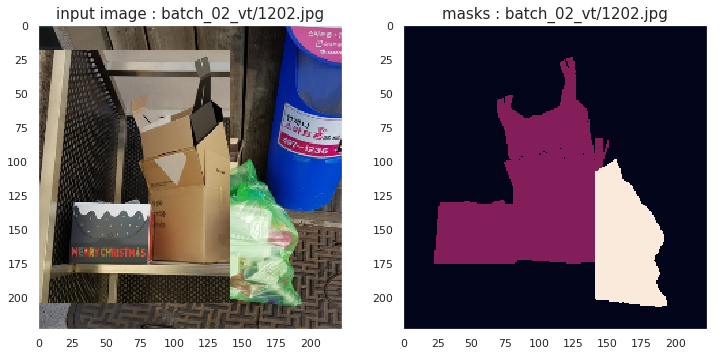

In [65]:
# train_loader의 output 결과(image 및 mask) 확인
for imgs, masks, image_infos in train_loader:
    image_infos = image_infos[0]
    temp_images = imgs
    temp_masks = masks
    
    break

###############################################
# cutmix
temp_images = torch.stack(temp_images)
temp_masks = torch.stack(temp_masks).long()
temp_images, temp_masks = cutmix(temp_images, temp_masks, 1.)
###############################################


fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 12))

print('image shape:', list(temp_images[0].shape))
print('mask shape: ', list(temp_masks[0].shape))
print('Unique values, category of transformed mask : \n', [{int(i),category_names[int(i)]} for i in list(np.unique(temp_masks[0]))])

ax1.imshow(temp_images[0].permute([1,2,0]))
ax1.grid(False)
ax1.set_title("input image : {}".format(image_infos['file_name']), fontsize = 15)

ax2.imshow(temp_masks[0])
ax2.grid(False)
ax2.set_title("masks : {}".format(image_infos['file_name']), fontsize = 15)

plt.show()

## train, validation, test 함수 정의

In [66]:
def train(num_epochs, model, data_loader, val_loader, criterion, optimizer, saved_dir, val_every, device):
    print('Start training..')
    best_loss = 9999999
    best_mIoU = 0
    for epoch in range(num_epochs):
        model.train()
        for step, (images, masks, _) in enumerate(data_loader):
            images = torch.stack(images)       # (batch, channel, height, width)
            masks = torch.stack(masks).long()  # (batch, channel, height, width)
            
            # gpu 연산을 위해 device 할당
            images, masks = images.to(device), masks.to(device)

            #####################################
            # 50% 확률로 CutMix
            mix_decision = np.random.rand()
            if mix_decision < 0.5:
                # cutmix(data, target, alpha)
                images, masks = cutmix(images, masks, 1.)
            #####################################
                  
            # inference
            outputs = model(images)
            
            # loss 계산 (cross entropy loss)
            loss = criterion(outputs, masks)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # step 주기에 따른 loss 출력
            if (step + 1) % 25 == 0:
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(
                    epoch+1, num_epochs, step+1, len(train_loader), loss.item()))
        
        # validation 주기에 따른 loss 출력 및 best model 저장
        if (epoch + 1) % val_every == 0:
            avrg_loss, mIoU = validation(epoch + 1, model, val_loader, criterion, device)
            if avrg_loss < best_loss:
                print('[loss] Best performance at epoch: {}'.format(epoch + 1))
                print('Save model in', saved_dir)
                best_loss = avrg_loss
                save_model(model, saved_dir, file_name ='loss_best_model(pretrained).pt')
            if mIoU > best_mIoU:
                print('[mIoU] Best performance at epoch: {}'.format(epoch + 1))
                print('Save model in', saved_dir)
                best_mIoU = mIoU
                save_model(model, saved_dir, file_name = 'mIoU_best_model(pretrained).pt')

In [67]:
def validation(epoch, model, data_loader, criterion, device):
    print('Start validation #{}'.format(epoch))
    model.eval()
    hist = np.zeros((12, 12))
    with torch.no_grad():
        total_loss = 0
        cnt = 0
        for step, (images, masks, _) in enumerate(data_loader):
            
            images = torch.stack(images).to(device)       # (batch, channel, height, width)
            masks = torch.stack(masks).long().to(device)  # (batch, channel, height, width)

            outputs = model(images)
            loss = criterion(outputs, masks)
            total_loss += loss
            cnt += 1
            
            outputs = torch.argmax(outputs, dim=1).detach().cpu().numpy()
            
            hist = add_hist(hist, masks.detach().cpu().numpy(), outputs, n_class=12)
            
        acc, acc_cls, mIoU, fwavacc = label_accuracy_score(hist)    
        avrg_loss = total_loss / cnt
        print('Validation #{}  Average Loss: {:.4f}, mIoU: {:.4f}, acc : {:.4f}'.format(epoch, avrg_loss, mIoU, acc))

    return avrg_loss, mIoU

## 모델 저장 함수 정의

In [68]:
# 모델 저장 함수 정의
val_every = 1 

saved_dir = './saved'
if not os.path.isdir(saved_dir):                                                           
    os.mkdir(saved_dir)
    
def save_model(model, saved_dir, file_name='fcn8s_best_model(pretrained).pt'):
    check_point = {'net': model.state_dict()}
    output_path = os.path.join(saved_dir, file_name)
    torch.save(model.state_dict(), output_path)

## 모델 생성 및 Loss function, Optimizer 정의

In [69]:
# Loss function 정의
criterion = nn.CrossEntropyLoss()

# Optimizer 정의
optimizer = torch.optim.Adam(params = model.parameters(), lr = learning_rate, weight_decay=1e-6)

In [70]:
train(num_epochs, model, train_loader, val_loader, criterion, optimizer, saved_dir, val_every, device)

Start training..


RuntimeError: CUDA out of memory. Tried to allocate 18.00 MiB (GPU 0; 23.88 GiB total capacity; 5.96 GiB already allocated; 9.88 MiB free; 6.22 GiB reserved in total by PyTorch)

## 저장된 model 불러오기 (학습된 이후) 

In [ ]:
# best model 저장된 경로
model_path = './saved/fcn8s_best_model(pretrained).pt'

# best model 불러오기
checkpoint = torch.load(model_path, map_location=device)
model.load_state_dict(checkpoint)

# 추론을 실행하기 전에는 반드시 설정 (batch normalization, dropout 를 평가 모드로 설정)
# model.eval()

In [ ]:
# 첫번째 batch의 추론 결과 확인
for imgs, image_infos in test_loader:
    image_infos = image_infos
    temp_images = imgs
    
    model.eval()
    # inference
    outs = model(torch.stack(temp_images).to(device))
    oms = torch.argmax(outs.squeeze(), dim=1).detach().cpu().numpy()
    
    break

i = 3
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 16))

print('Shape of Original Image :', list(temp_images[i].shape))
print('Shape of Predicted : ', list(oms[i].shape))
print('Unique values, category of transformed mask : \n', [{int(i),category_names[int(i)]} for i in list(np.unique(oms[i]))])

# Original image
ax1.imshow(temp_images[i].permute([1,2,0]))
ax1.grid(False)
ax1.set_title("Original image : {}".format(image_infos[i]['file_name']), fontsize = 15)

# Predicted
ax2.imshow(oms[i])
ax2.grid(False)
ax2.set_title("Predicted : {}".format(image_infos[i]['file_name']), fontsize = 15)

plt.show()

## submission을 위한 test 함수 정의

In [ ]:
from tqdm import tqdm

def test(model, data_loader, device):
    size = 256
    transform = A.Compose([A.Resize(256, 256)])
    print('Start prediction.')
    model.eval()
    
    file_name_list = []
    preds_array = np.empty((0, size*size), dtype=np.long)
    
    with torch.no_grad():
        for step, (imgs, image_infos) in tqdm(enumerate(test_loader)):

            # inference (512 x 512)
            outs = model(torch.stack(imgs).to(device))
            oms = torch.argmax(outs.squeeze(), dim=1).detach().cpu().numpy()
            
            # resize (256 x 256)
            temp_mask = []
            for img, mask in zip(np.stack(imgs), oms):
                transformed = transform(image=img, mask=mask)
                mask = transformed['mask']
                temp_mask.append(mask)

            oms = np.array(temp_mask)
            
            oms = oms.reshape([oms.shape[0], size*size]).astype(int)
            preds_array = np.vstack((preds_array, oms))
            
            file_name_list.append([i['file_name'] for i in image_infos])
    print("End prediction.")
    file_names = [y for x in file_name_list for y in x]
    
    return file_names, preds_array

## submission.csv 생성

In [ ]:


# sample_submisson.csv 열기
submission = pd.read_csv('./submission/sample_submission.csv', index_col=None)

# test set에 대한 prediction
file_names, preds = test(model, test_loader, device)

# PredictionString 대입
for file_name, string in tqdm(zip(file_names, preds)):
    submission = submission.append({"image_id" : file_name, "PredictionString" : ' '.join(str(e) for e in string.tolist())}, 
                                   ignore_index=True)

# submission.csv로 저장
submission.to_csv("./submission/Baseline_FCN8s(pretrained).csv", index=False)

## Reference

